# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.ensembles import MultiResOceanStateEnsemble
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
%cuda_context_handler gpu_ctx_refined

## Selecting loc

As initial and boundary conditions to the simulation, we use data from the Norkyst800 s-level files:

In [5]:
nk800_url  = ["/sintef/data/NorKyst800/ocean_his.an.20190716.nc"]
nk800_url  = "C:\\Users\\florianb\\Documents\\havvarsel-data\\ocean_his.an.20190716.nc"

data_args = NetCDFInitialization.removeMetadata(NetCDFInitialization.getInitialConditionsNorKystCases(nk800_url, "lofoten", download_data=False, norkyst_data=False))
data_args.keys()

dict_keys(['nx', 'ny', 'dx', 'dy', 'g', 'r', 'H', 'eta0', 'hu0', 'hv0', 'angle', 'latitude', 'f', 'boundary_conditions_data', 'boundary_conditions', 'wind'])

In [6]:
sim_args = {
    "dt": 0.0,
    "write_netcdf":False,
    "model_time_step": 60
     }

## Simulation

In [7]:
from gpuocean.SWEsimulators import CDKLM16

sim = CDKLM16.CDKLM16(gpu_ctx, **sim_args, **data_args)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [8]:
sim.step(60)

60.0

### Refined Simulation

Defining local area

In [9]:
# [[y0,x0],[y1,x1]]
loc = [[100, 100], [200,300]]

scale = 1.2

In [10]:
sim.give_birth(gpu_ctx_refined, loc, scale)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Use halo mask according to bathymetry
Construct halo mask according to finer bathymetry information!


In [11]:
# Extract child sim for manual handling 
sim_refined = sim.children[0]
sim.children = []

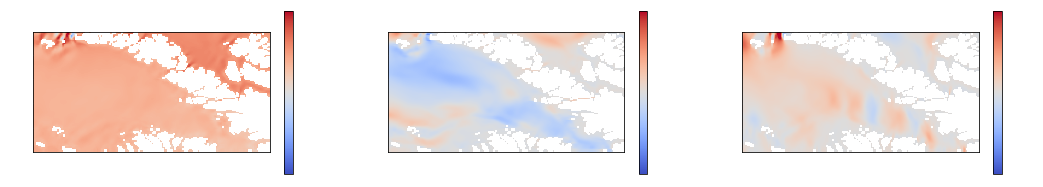

In [12]:
eta_refined, hu_refined, hv_refined = sim_refined.download()

fig, axs = plt.subplots(1,3, figsize=(18,6))
im = axs[0].imshow(eta_refined, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar(im, ax=axs[0], shrink=0.5)
im = axs[1].imshow(hu_refined, vmin=-100, vmax=100, cmap="coolwarm")
plt.colorbar(im, ax=axs[1], shrink=0.5)
im = axs[2].imshow(hv_refined, vmin=-100, vmax=100, cmap="coolwarm")
plt.colorbar(im, ax=axs[2], shrink=0.5)

### Time-Stepping

Coarse step (gives BC for fine step)

In [25]:
eta, hu, hv = sim.download()
t0 = sim.t
bc_data_north_t0 = [x[loc[1][0]+1, loc[0][1]:loc[1][1]] for x in [eta, hu, hv]]
bc_data_south_t0 = [x[loc[0][0]-1, loc[0][1]:loc[1][1]] for x in [eta, hu, hv]]
bc_data_west_t0 = [x[loc[0][0]:loc[1][0], loc[0][1]-1] for x in [eta, hu, hv]]
bc_data_east_t0 = [x[loc[0][0]:loc[1][0], loc[1][1]+1] for x in [eta, hu, hv]]

In [26]:
sim.step(sim.model_time_step)

3660.0

In [27]:
eta, hu, hv = sim.download()
t1 = sim.t
bc_data_north_t1 = [x[loc[1][0]+1, loc[0][1]:loc[1][1]] for x in [eta, hu, hv]]
bc_data_south_t1 = [x[loc[0][0]-1, loc[0][1]:loc[1][1]] for x in [eta, hu, hv]]
bc_data_west_t1 = [x[loc[0][0]:loc[1][0], loc[0][1]-1] for x in [eta, hu, hv]]
bc_data_east_t1 = [x[loc[0][0]:loc[1][0], loc[1][1]+1] for x in [eta, hu, hv]]

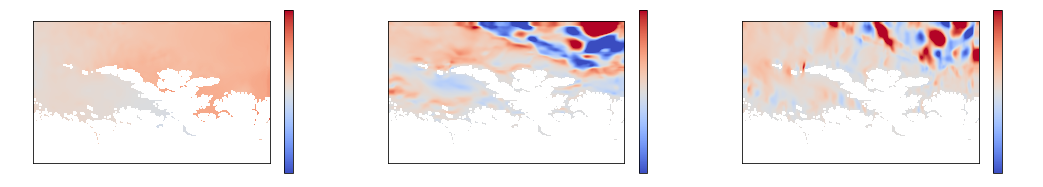

In [28]:
eta, hu, hv = sim.download()

fig, axs = plt.subplots(1,3, figsize=(18,6))
im = axs[0].imshow(eta, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar(im, ax=axs[0], shrink=0.5)
im = axs[1].imshow(hu, vmin=-100, vmax=100, cmap="coolwarm")
plt.colorbar(im, ax=axs[1], shrink=0.5)
im = axs[2].imshow(hv, vmin=-100, vmax=100, cmap="coolwarm")
plt.colorbar(im, ax=axs[2], shrink=0.5)

Set BC for fine and step

In [29]:
from gpuocean.utils import Common
t = [t0, t1]
for cardinal in ["north", "south", "east", "west"]:
    exec("{0} = Common.SingleBoundaryConditionData(h = [bc_data_{0}_t0[0], bc_data_{0}_t1[0]],\
                                            hu = [bc_data_{0}_t0[1], bc_data_{0}_t1[1]],\
                                            hv = [bc_data_{0}_t0[2], bc_data_{0}_t1[2]])".format(cardinal))
bc_data = Common.BoundaryConditionsData(t=t, north=north, south=south, east=east, west=west)

In [30]:
sim_refined.bc_kernel = Common.BoundaryConditionsArakawaA(gpu_ctx_refined, sim_refined.nx, sim_refined.ny, 2, 2, \
                                                           sim_refined.boundary_conditions, bc_data)


In [31]:
sim_refined.step(sim.model_time_step)

3660.0

Replace coarse with fine values

In [21]:
from gpuocean.utils import OceanographicUtilities
eta_refined, hu_refined, hv_refined = sim_refined.download(interior_domain_only=True)

eta_loc = OceanographicUtilities.rescaleMidpoints(eta_refined, loc[1][1]-loc[0][1], loc[1][0]-loc[0][0])[2]
hu_loc  = OceanographicUtilities.rescaleMidpoints(hu_refined,  loc[1][1]-loc[0][1], loc[1][0]-loc[0][0])[2]
hv_loc  = OceanographicUtilities.rescaleMidpoints(hv_refined,  loc[1][1]-loc[0][1], loc[1][0]-loc[0][0])[2]

eta, hu, hv = sim.download()
eta[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]] = eta_loc
hu[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]]  = hu_loc
hv[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]]  = hv_loc
sim.upload(eta, hu, hv)

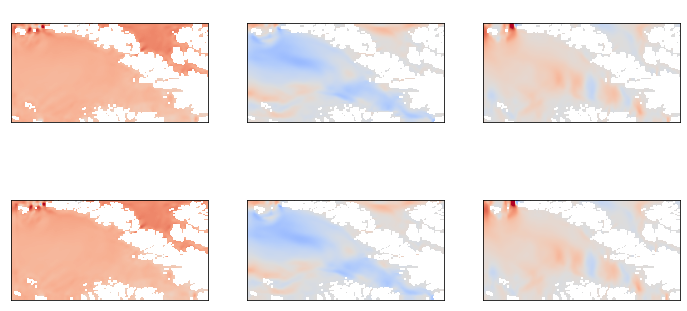

In [22]:
eta, hu, hv = sim.download()
eta_refined, hu_refined, hv_refined = sim_refined.download()

fig, axs = plt.subplots(2,3,figsize=(12,6))

axs[0,0].imshow(eta[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], origin="lower", vmin=-1, vmax=1, cmap="coolwarm")
axs[0,0].set_title("eta (coarse)")
axs[0,1].imshow(hu[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[0,1].set_title("hu (coarse)")
axs[0,2].imshow(hv[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[0,2].set_title("hv (coarse)")

axs[1,0].imshow(eta_refined, origin="lower", vmin=-1, vmax=1, cmap="coolwarm")
axs[1,0].set_title("eta (refined)")
axs[1,1].imshow(hu_refined, origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[1,1].set_title("hu (refined)")
axs[1,2].imshow(hv_refined, origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[1,2].set_title("hv (refined)")

for ax_s in axs:
    for ax in ax_s:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

Repeated model time steps

In [23]:
while sim.t < 3600:
    eta, hu, hv = sim.download()
    t0 = sim.t
    bc_data_north_t0 = [x[loc[1][0]+1, loc[0][1]:loc[1][1]] for x in [eta, hu, hv]]
    bc_data_south_t0 = [x[loc[0][0]-1, loc[0][1]:loc[1][1]] for x in [eta, hu, hv]]
    bc_data_west_t0 = [x[loc[0][0]:loc[1][0], loc[0][1]-1] for x in [eta, hu, hv]]
    bc_data_east_t0 = [x[loc[0][0]:loc[1][0], loc[1][1]+1] for x in [eta, hu, hv]]

    sim.step(sim.model_time_step)

    eta, hu, hv = sim.download()
    t1 = sim.t
    bc_data_north_t1 = [x[loc[1][0]+1, loc[0][1]:loc[1][1]] for x in [eta, hu, hv]]
    bc_data_south_t1 = [x[loc[0][0]-1, loc[0][1]:loc[1][1]] for x in [eta, hu, hv]]
    bc_data_west_t1 = [x[loc[0][0]:loc[1][0], loc[0][1]-1] for x in [eta, hu, hv]]
    bc_data_east_t1 = [x[loc[0][0]:loc[1][0], loc[1][1]+1] for x in [eta, hu, hv]]

    t = [t0, t1]
    for cardinal in ["north", "south", "east", "west"]:
        exec("{0} = Common.SingleBoundaryConditionData(h = [bc_data_{0}_t0[0], bc_data_{0}_t1[0]],\
                                                hu = [bc_data_{0}_t0[1], bc_data_{0}_t1[1]],\
                                                hv = [bc_data_{0}_t0[2], bc_data_{0}_t1[2]])".format(cardinal))
    bc_data = Common.BoundaryConditionsData(t=t, north=north, south=south, east=east, west=west)

    sim_refined.bc_kernel = Common.BoundaryConditionsArakawaA(gpu_ctx_refined, sim_refined.nx, sim_refined.ny, 2, 2, \
                                                           sim_refined.boundary_conditions, bc_data)

    sim_refined.step(sim.model_time_step)

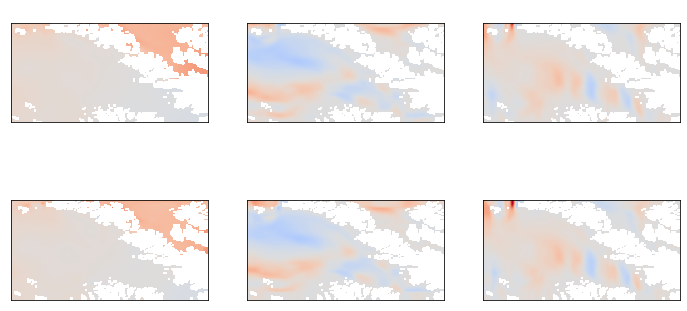

In [24]:
eta, hu, hv = sim.download()
eta_refined, hu_refined, hv_refined = sim_refined.download()

fig, axs = plt.subplots(2,3,figsize=(12,6))

axs[0,0].imshow(eta[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], origin="lower", vmin=-1, vmax=1, cmap="coolwarm")
axs[0,0].set_title("eta (coarse)")
axs[0,1].imshow(hu[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[0,1].set_title("hu (coarse)")
axs[0,2].imshow(hv[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[0,2].set_title("hv (coarse)")

axs[1,0].imshow(eta_refined, origin="lower", vmin=-1, vmax=1, cmap="coolwarm")
axs[1,0].set_title("eta (refined)")
axs[1,1].imshow(hu_refined, origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[1,1].set_title("hu (refined)")
axs[1,2].imshow(hv_refined, origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[1,2].set_title("hv (refined)")

for ax_s in axs:
    for ax in ax_s:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])